# 2022.3.31

In [1]:
DATASET = "../dataset/MMS.csv"
TOPOLOGY = "../dataset/MMS_topology.pk"
RESULT="../topomad-1-results/MMS_GAT"
NAME="performance_evaluation_GAT"

In [2]:
import pandas as pd
from graph_lstm_vae_ad_ver6 import GraphLSTM_VAE_AD
from graph_lstm_vae_ad_ver6 import GraphLSTM_VAE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import os
import pickle
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_choice =1

# 读数据

In [3]:
data = pd.read_csv(DATASET, header=[0,1])

# 参数

In [4]:
seq_len = 10
num_epo = 150
hid_dim = 3
lea_rat = 1e-4
nod_num = 50
sam_num = 20
del_tol = 5
tra_siz = len(data)//3*2

# 预处理标准化

In [5]:
metric = data.drop(['TimeStamp', 'label'], axis = 1)
metric.columns.names = ['pod','metric']
tempm = metric.swaplevel('metric','pod',axis=1).stack()
tempm = (tempm-tempm.mean())/(tempm.std())
metric = tempm.unstack().swaplevel('metric','pod',axis=1).stack().unstack()

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


# 读拓扑

In [6]:
with open(TOPOLOGY, 'rb') as f:
    edge_index = pickle.load(f)

# 训练VAE

Epoch [150/150], Iter [60/63], total_loss: -3114.8696, recon_loss: -3238.7993, kl_loss: 123.9297
valid_loss: [1902.1098542390046, 1890.4664351851852, 1889.5215612340855, 1885.2240532769097, 1879.4786150896991, 1873.1315872757523, 1866.0548909505208, 1858.4723036024307, 1845.4592511212384, 1827.916173864294, 1813.3403998480903, 1793.9379837601273, 1771.5801775896991, 1742.875244140625, 1711.5475893373844, 1676.6402587890625, 1641.4442862051505, 1600.7612937644676, 1555.3116274233219, 1510.1193305121528, 1455.3534839771412, 1408.0105116102432, 1358.836999963831, 1298.3535698784722, 1240.638888888889, 1181.785201461227, 1124.8612173574943, 1061.206251356337, 1002.1657986111111, 938.7252061631945, 874.2631655092592, 812.7039930555555, 749.9189724392361, 684.8127667462385, 622.4729150842737, 558.4577444571036, 497.4254059968171, 435.58810537832755, 376.5621891728154, 317.76789403844765, 257.20814231589986, 197.52807843243633, 142.19314900151005, 88.66382683648004, 31.947635014851887, -21.27

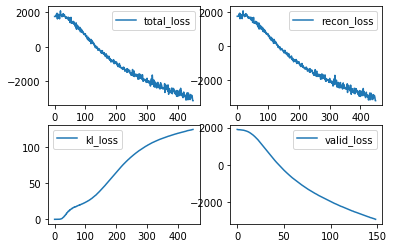

100%|██████████| 27/27 [00:04<00:00,  5.41it/s]
/home/user/hzl/bishe-mms/faster/graph_lstm_vae_ad_ver6/graphlstm_vae_ad.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.interpolate(inplace=True)
/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
100%|██████████| 91/91 [05:14<00:00,  3.46s/it]
/home/user/hzl/bishe-mms/faster/graph_lstm_vae_ad_ver6/graphlstm_vae_ad.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

In [7]:
#checklist：ver，name，seedi，filename
from sklearn.metrics import average_precision_score
import pickle
aps = []
maps = []
traintime150s = []
testtimes = []
for seedi in range(5):
    model = GraphLSTM_VAE_AD(name=NAME+"VAE", sequence_length=seq_len, num_epochs=num_epo, hidden_dim=hid_dim, lr=lea_rat, gpu = gpu_choice, variational = True, kind = 'GAT',seed=seedi, head=(8,8),dropout=(0.4,0.4), bias=(True, False))
    traintime150_start=time.time()
    model.fit(metric[:tra_siz],nod_num, edge_index)
    traintime150_end=time.time()
    traintime150s.append(traintime150_end-traintime150_start)
    
    testtime_start=time.time()
    pred = model.predict(metric[tra_siz:],nod_num, edge_index, sam_num, del_tol)[1]
    testtime_end=time.time()
    testtimes.append(testtime_end-testtime_start)
    
    
    pred_t = model.predict(metric[:tra_siz], nod_num, edge_index, sam_num, del_tol)[1]
    itp=model.interpret(metric[tra_siz:],nod_num, edge_index, sam_num, del_tol)
    
    ap = average_precision_score(data['label'][tra_siz+seq_len-del_tol:],pred)
    aps.append(ap)
    
    mapp = np.mean((average_precision_score(data['label'][tra_siz+seq_len-del_tol:],pred), average_precision_score(1-data['label'][tra_siz+seq_len-del_tol:],-pred)))
    maps.append(mapp)

In [8]:
print(aps)
print(maps)

[0.4462160801927483, 0.44372309041878705, 0.44660133686480613, 0.4336803893331019, 0.44448847595533636]
[0.7017540271888626, 0.7001474716919016, 0.703124354838257, 0.6950519193362847, 0.7026275175784651]


In [9]:
np.mean(maps)

0.7005410581267542

In [10]:
np.mean(aps)

0.4429418745529559

In [11]:
print(traintime150s)

[5691.759789466858, 5663.735559225082, 5544.284799575806, 5504.859639167786, 5543.792522907257]


In [12]:
np.mean(traintime150s)/60

93.16144103447596